In [1]:
import os
import json
from pathlib import Path
import shutil
import random
import numpy as np

from datasets import load_dataset

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
os.environ["TOKENIZERS_PARALLELISM"] = "false"

### Build Dataset and push to HuggingFace Hub:

In [2]:
data_dir = "/home/harish3110/document-ai/data/og_data"

In [3]:
base_path = Path(data_dir)
metadata_path = base_path.joinpath("key")
image_path = base_path.joinpath("img")
# define metadata list
metadata_list = []

# parse metadata
for file_name in metadata_path.glob("*.json"):
  with open(file_name, "r") as json_file:
    # load json file
    data = json.load(json_file)
    data = {"gt_parse": data}
    # # create "text" column with json string
    text = json.dumps(data)
    # add to metadata list if image exists
    if image_path.joinpath(f"{file_name.stem}.jpeg").is_file():    
      metadata_list.append({"ground_truth":text, "file_name": f"{file_name.stem}.jpeg"})
      # delete json file

# write jsonline file
with open(image_path.joinpath('metadata.jsonl'), 'w') as outfile:
    for entry in metadata_list:
        json.dump(entry, outfile)
        outfile.write('\n')

# Load dataset
dataset = load_dataset("imagefolder", data_dir=image_path, split="train")

print(f"Dataset has {len(dataset)} images")
print(f"Dataset features are: {dataset.features.keys()}")

Resolving data files:   0%|          | 0/5590 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset imagefolder downloaded and prepared to /home/harish3110/.cache/huggingface/datasets/imagefolder/default-3f442acae7c0615c/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f. Subsequent calls will reuse this data.
Dataset has 5589 images
Dataset features are: dict_keys(['image', 'ground_truth'])


In [4]:
from datasets import DatasetDict

# 80% train, 20% test + validation
train_testvalid = dataset.train_test_split(test_size=0.2)
# Split the 20% test + valid in half test, half valid
test_valid = train_testvalid['test'].train_test_split(test_size=0.5)
# gather everyone if you want to have a single DatasetDict
dataset = DatasetDict({
    'train': train_testvalid['train'],
    'test': test_valid['test'],
    'valid': test_valid['train']})

In [5]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'ground_truth'],
        num_rows: 4471
    })
    test: Dataset({
        features: ['image', 'ground_truth'],
        num_rows: 559
    })
    valid: Dataset({
        features: ['image', 'ground_truth'],
        num_rows: 559
    })
})

In [4]:
dataset_name = "harish3110/quandri-nanonets-annotations-all-data"
# dataset_name = "harish3110/quandri-nanonets-annotations-all"
# dataset_name = "harish3110/donut-quandri"

In [7]:
# dataset.push_to_hub(dataset_name, private=True)

Pushing split train to the Hub.


Map:   0%|          | 0/746 [00:00<?, ? examples/s]

Pushing dataset shards to the dataset hub:   0%|          | 0/6 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

### Load Dataset

In [4]:
dataset_name = "harish3110/quandri-nanonets-annotations-all-data"

In [5]:
dataset = load_dataset(dataset_name)
dataset

Found cached dataset parquet (/home/harish3110/.cache/huggingface/datasets/harish3110___parquet/harish3110--quandri-nanonets-annotations-all-data-703c7fe06f02732b/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    test: Dataset({
        features: ['image', 'ground_truth'],
        num_rows: 559
    })
    valid: Dataset({
        features: ['image', 'ground_truth'],
        num_rows: 559
    })
    train: Dataset({
        features: ['image', 'ground_truth'],
        num_rows: 4471
    })
})

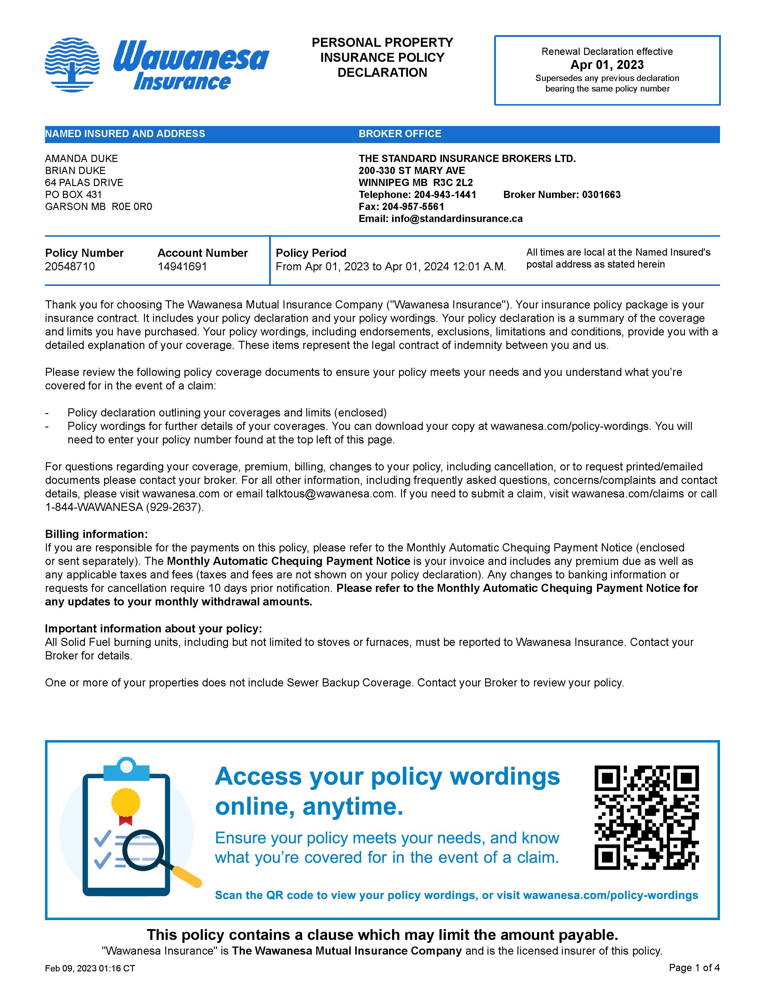

In [6]:
example = dataset['train'][590]
image = example['image']
# let's make the image a bit smaller when visualizing
width, height = image.size
display(image.resize((int(width*0.3), int(height*0.3))))

In [7]:
# let's load the corresponding JSON dictionary (as string representation)
ground_truth = example['ground_truth']
print(ground_truth)

{"gt_parse": {"effective_document_date": "Apr 01 , 2023", "document_type_description": "Renewal Declaration effective", "broker_name": "THE STANDARD INSURANCE BROKERS LTD .", "broker_address": "WINNIPEG MB R3C 2L2 200-330 ST MARY AVE", "policy_number": "20548710", "effective_date": "Apr 01 , 2023 to", "expiry_date": "Apr 01 , 2024", "customer_name": "AMANDA DUKE \nBRIAN DUKE", "customer_address": "64 PALAS DRIVE \nPO BOX 431 \nGARSON MB ROE ORO", "policy_type": "PERSONAL PROPERTY \nINSURANCE POLICY", "document_type": "DECLARATION", "premium": "Wawanesa \nInsurance"}}


In [8]:
type(example['ground_truth'])

str

In [20]:
from ast import literal_eval

literal_eval(ground_truth)['gt_parse']

{'effective_document_date': 'Apr 01 , 2023',
 'document_type_description': 'Renewal Declaration effective',
 'broker_name': 'THE STANDARD INSURANCE BROKERS LTD .',
 'broker_address': 'WINNIPEG MB R3C 2L2 200-330 ST MARY AVE',
 'policy_number': '20548710',
 'effective_date': 'Apr 01 , 2023 to',
 'expiry_date': 'Apr 01 , 2024',
 'customer_name': 'AMANDA DUKE \nBRIAN DUKE',
 'customer_address': '64 PALAS DRIVE \nPO BOX 431 \nGARSON MB ROE ORO',
 'policy_type': 'PERSONAL PROPERTY \nINSURANCE POLICY',
 'document_type': 'DECLARATION',
 'premium': 'Wawanesa \nInsurance'}

### Load model and processor

In [9]:
from transformers import VisionEncoderDecoderConfig

image_size = [1280, 960]
max_length = 768

# update image_size of the encoder
# during pre-training, a larger image size was used
config = VisionEncoderDecoderConfig.from_pretrained("naver-clova-ix/donut-base")
config.encoder.image_size = image_size # (height, width)
# update max_length of the decoder (for generation)
config.decoder.max_length = max_length
# TODO we should actually update max_position_embeddings and interpolate the pre-trained ones:
# https://github.com/clovaai/donut/blob/0acc65a85d140852b8d9928565f0f6b2d98dc088/donut/model.py#L602

In [10]:
from transformers import DonutProcessor, VisionEncoderDecoderModel

processor = DonutProcessor.from_pretrained("naver-clova-ix/donut-base")
model = VisionEncoderDecoderModel.from_pretrained("naver-clova-ix/donut-base", config=config)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


### Create PyTorch Dataset:

In [13]:
import json
import random
from typing import Any, List, Tuple

import torch
from torch.utils.data import Dataset

added_tokens = []

class DonutDataset(Dataset):
    """
    DonutDataset which is saved in huggingface datasets format. (see details in https://huggingface.co/docs/datasets)
    Each row, consists of image path(png/jpg/jpeg) and gt data (json/jsonl/txt),
    and it will be converted into input_tensor(vectorized image) and input_ids(tokenized string).
    Args:
        dataset_name_or_path: name of dataset (available at huggingface.co/datasets) or the path containing image files and metadata.jsonl
        max_length: the max number of tokens for the target sequences
        split: whether to load "train", "validation" or "test" split
        ignore_id: ignore_index for torch.nn.CrossEntropyLoss
        task_start_token: the special token to be fed to the decoder to conduct the target task
        prompt_end_token: the special token at the end of the sequences
        sort_json_key: whether or not to sort the JSON keys
    """

    def __init__(
        self,
        dataset_name_or_path: str,
        max_length: int,
        split: str = "train",
        ignore_id: int = -100,
        task_start_token: str = "<s>",
        prompt_end_token: str = None,
        sort_json_key: bool = True,
    ):
        super().__init__()

        self.max_length = max_length
        self.split = split
        self.ignore_id = ignore_id
        self.task_start_token = task_start_token
        self.prompt_end_token = prompt_end_token if prompt_end_token else task_start_token
        self.sort_json_key = sort_json_key

        self.dataset = load_dataset(dataset_name_or_path, split=self.split)
        self.dataset_length = len(self.dataset)

        self.gt_token_sequences = []
        for sample in self.dataset:
            ground_truth = json.loads(sample["ground_truth"])
            if "gt_parses" in ground_truth:  # when multiple ground truths are available, e.g., docvqa
                assert isinstance(ground_truth["gt_parses"], list)
                gt_jsons = ground_truth["gt_parses"]
            else:
                assert "gt_parse" in ground_truth and isinstance(ground_truth["gt_parse"], dict)
                gt_jsons = [ground_truth["gt_parse"]]

            self.gt_token_sequences.append(
                [
                    self.json2token(
                        gt_json,
                        update_special_tokens_for_json_key=self.split == "train",
                        sort_json_key=self.sort_json_key,
                    )
                    + processor.tokenizer.eos_token
                    for gt_json in gt_jsons  # load json from list of json
                ]
            )

        self.add_tokens([self.task_start_token, self.prompt_end_token])
        self.prompt_end_token_id = processor.tokenizer.convert_tokens_to_ids(self.prompt_end_token)

    def json2token(self, obj: Any, update_special_tokens_for_json_key: bool = True, sort_json_key: bool = True):
        """
        Convert an ordered JSON object into a token sequence
        """
        if type(obj) == dict:
            if len(obj) == 1 and "text_sequence" in obj:
                return obj["text_sequence"]
            else:
                output = ""
                if sort_json_key:
                    keys = sorted(obj.keys(), reverse=True)
                else:
                    keys = obj.keys()
                for k in keys:
                    if update_special_tokens_for_json_key:
                        self.add_tokens([fr"<s_{k}>", fr"</s_{k}>"])
                    output += (
                        fr"<s_{k}>"
                        + self.json2token(obj[k], update_special_tokens_for_json_key, sort_json_key)
                        + fr"</s_{k}>"
                    )
                return output
        elif type(obj) == list:
            return r"<sep/>".join(
                [self.json2token(item, update_special_tokens_for_json_key, sort_json_key) for item in obj]
            )
        else:
            obj = str(obj)
            if f"<{obj}/>" in added_tokens:
                obj = f"<{obj}/>"  # for categorical special tokens
            return obj

    def add_tokens(self, list_of_tokens: List[str]):
        """
        Add special tokens to tokenizer and resize the token embeddings of the decoder
        """
        newly_added_num = processor.tokenizer.add_tokens(list_of_tokens)
        if newly_added_num > 0:
            model.decoder.resize_token_embeddings(len(processor.tokenizer))
            added_tokens.extend(list_of_tokens)

    def __len__(self) -> int:
        return self.dataset_length

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Load image from image_path of given dataset_path and convert into input_tensor and labels
        Convert gt data into input_ids (tokenized string)
        Returns:
            input_tensor : preprocessed image
            input_ids : tokenized gt_data
            labels : masked labels (model doesn't need to predict prompt and pad token)
        """
        sample = self.dataset[idx]

        # inputs
        pixel_values = processor(sample["image"], random_padding=self.split == "train", return_tensors="pt").pixel_values
        pixel_values = pixel_values.squeeze()

        # targets
        target_sequence = random.choice(self.gt_token_sequences[idx])  # can be more than one, e.g., DocVQA Task 1
        input_ids = processor.tokenizer(
            target_sequence,
            add_special_tokens=False,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )["input_ids"].squeeze(0)

        labels = input_ids.clone()
        labels[labels == processor.tokenizer.pad_token_id] = self.ignore_id  # model doesn't need to predict pad token
        # labels[: torch.nonzero(labels == self.prompt_end_token_id).sum() + 1] = self.ignore_id  # model doesn't need to predict prompt (for VQA)
        return pixel_values, labels, target_sequence

In [14]:

# we update some settings which differ from pretraining; namely the size of the images + no rotation required
# source: https://github.com/clovaai/donut/blob/master/config/train_cord.yaml
processor.feature_extractor.size = image_size[::-1] # should be (width, height)
processor.feature_extractor.do_align_long_axis = False

train_dataset = DonutDataset(dataset_name, max_length=max_length,
                             split="train", task_start_token="<s_cord-v2>", prompt_end_token="<s_cord-v2>",
                             sort_json_key=False, # cord dataset is preprocessed, so no need for this
                             )

val_dataset = DonutDataset(dataset_name, max_length=max_length,
                             split="valid", task_start_token="<s_cord-v2>", prompt_end_token="<s_cord-v2>",
                             sort_json_key=False, # cord dataset is preprocessed, so no need for this
                             )

Found cached dataset parquet (/home/harish3110/.cache/huggingface/datasets/harish3110___parquet/harish3110--quandri-nanonets-annotations-all-data-703c7fe06f02732b/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
Found cached dataset parquet (/home/harish3110/.cache/huggingface/datasets/harish3110___parquet/harish3110--quandri-nanonets-annotations-all-data-703c7fe06f02732b/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


In [15]:
len(added_tokens)

0

In [16]:
print(added_tokens)

[]


In [17]:
# the vocab size attribute stays constants (might be a bit unintuitive - but doesn't include special tokens)
print("Original number of tokens:", processor.tokenizer.vocab_size)
print("Number of tokens after adding special tokens:", len(processor.tokenizer))

Original number of tokens: 57522
Number of tokens after adding special tokens: 57566


In [18]:
pixel_values, labels, target_sequence = train_dataset[0]

This returns the `pixel_values` (the image, but prepared for the model as a PyTorch tensor), the `labels` (which are the encoded `input_ids` of the target sequence, which we want Donut to learn to generate) and the original `target_sequence`. The reason we also return the latter is because this will allow us to compute metrics between the generated sequences and the ground truth target sequences.

In [29]:
print(pixel_values.shape)

torch.Size([3, 1280, 960])


In [19]:
# let's print the labels (the first 30 token ID's)
for id in labels.tolist()[:30]:
  if id != -100:
    print(processor.decode([id]))
  else:
    print(id)

<s_insurance_carrier>
Red
River
Mu
tual
</s_insurance_carrier>
<s_policy_number>
01
120
89
10
9
</s_policy_number>
</s>
-100
-100
-100
-100
-100
-100
-100
-100
-100
-100
-100
-100
-100
-100
-100
-100


In [20]:
# let's check the corresponding target sequence, as a string
print(target_sequence)

<s_insurance_carrier>Red River 
Mutual</s_insurance_carrier><s_policy_number>0112089109</s_policy_number></s>


Another important thing is that we need to set 2 additional attributes in the configuration of the model. This is not required, but will allow us to train the model by only providing the decoder targets, without having to provide any decoder inputs.

The model will automatically create the `decoder_input_ids` (the decoder inputs) based on the `labels`, by shifting them one position to the right and prepending the decoder_start_token_id. I recommend checking [this video](https://www.youtube.com/watch?v=IGu7ivuy1Ag&t=888s&ab_channel=NielsRogge) if you want to understand how models like Donut automatically create decoder_input_ids - and more broadly how Donut works.

In [21]:
model.config.pad_token_id = processor.tokenizer.pad_token_id
model.config.decoder_start_token_id = processor.tokenizer.convert_tokens_to_ids(['<s_cord-v2>'])[0]

In [22]:
# sanity check
print("Pad token ID:", processor.decode([model.config.pad_token_id]))
print("Decoder start token ID:", processor.decode([model.config.decoder_start_token_id]))

Pad token ID: <pad>
Decoder start token ID: <s_cord-v2>


### Create PyTorch Dataloaders

In [23]:
from torch.utils.data import DataLoader

# feel free to increase the batch size if you have a lot of memory
# I'm fine-tuning on Colab and given the large image size, batch size > 1 is not feasible
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=4)

In [24]:
batch = next(iter(train_dataloader))
pixel_values, labels, target_sequences = batch
print(pixel_values.shape)

torch.Size([1, 3, 1280, 960])


In [25]:
for id in labels.squeeze().tolist()[:30]:
  if id != -100:
    print(processor.decode([id]))
  else:
    print(id)

<s_customer_address>
PO

BOX
16
18
S
TN
M
AIN
S
WI
FT
CU
RR
ENT
SK
S
9
H
4
G
5
</s_customer_address>
<s_broker_address>
208
C
ENT
RAL



In [26]:
print(len(train_dataset))
print(len(val_dataset))

4471
559


In [27]:
# let's check the first validation batch
batch = next(iter(val_dataloader))
pixel_values, labels, target_sequences = batch
print(pixel_values.shape)

torch.Size([1, 3, 1280, 960])


In [28]:
print(target_sequences[0])

<s_broker_address>BOX 208 , 59 MAIN STREET S 
CARMAN , MANITOBA 
ROG OJO</s_broker_address><s_broker_name>BSI INSURANCE BROKERS LTD .</s_broker_name><s_customer_address>PO BOX 425 
CARMAN , MB 
ROG OJO</s_customer_address><s_customer_name>KIPPEN , CURTIS</s_customer_name><s_document_type_description>Renewal</s_document_type_description><s_effective_document_date>22 Nov 2021</s_effective_document_date><s_expiry_date>22 Nov 2022</s_expiry_date><s_effective_date>22 Nov 2021</s_effective_date><s_policy_number>4M0519771</s_policy_number><s_policy_type>Personal Property Insurance</s_policy_type><s_insurance_carrier>intact 
INSURANCE</s_insurance_carrier><s_copy_type>BROKER COPY (</s_copy_type></s>


## Define LightningModule

Next, we define a [LightningModule](https://pytorch-lightning.readthedocs.io/en/stable/common/lightning_module.html), which is the standard way to train a model in PyTorch Lightning. A LightningModule is an `nn.Module` with some additional functionality. 

Basically, PyTorch Lightning will take care of all device placements (`.to(device)`) for us, as well as the backward pass, putting the model in training mode, etc.

In [29]:
from pathlib import Path
import re
from nltk import edit_distance
import numpy as np
import math

from torch.nn.utils.rnn import pad_sequence
from torch.optim.lr_scheduler import LambdaLR

import pytorch_lightning as pl
from pytorch_lightning.utilities import rank_zero_only


class DonutModelPLModule(pl.LightningModule):
    def __init__(self, config, processor, model):
        super().__init__()
        self.config = config
        self.processor = processor
        self.model = model

    def training_step(self, batch, batch_idx):
        pixel_values, labels, _ = batch
        
        outputs = self.model(pixel_values, labels=labels)
        loss = outputs.loss
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx, dataset_idx=0):
        pixel_values, labels, answers = batch
        batch_size = pixel_values.shape[0]
        # we feed the prompt to the model
        decoder_input_ids = torch.full((batch_size, 1), self.model.config.decoder_start_token_id, device=self.device)
        
        outputs = self.model.generate(pixel_values,
                                   decoder_input_ids=decoder_input_ids,
                                   max_length=max_length,
                                   early_stopping=True,
                                   pad_token_id=self.processor.tokenizer.pad_token_id,
                                   eos_token_id=self.processor.tokenizer.eos_token_id,
                                   use_cache=True,
                                   num_beams=1,
                                   bad_words_ids=[[self.processor.tokenizer.unk_token_id]],
                                   return_dict_in_generate=True,)
    
        predictions = []
        for seq in self.processor.tokenizer.batch_decode(outputs.sequences):
            seq = seq.replace(self.processor.tokenizer.eos_token, "").replace(self.processor.tokenizer.pad_token, "")
            seq = re.sub(r"<.*?>", "", seq, count=1).strip()  # remove first task start token
            predictions.append(seq)

        scores = []
        for pred, answer in zip(predictions, answers):
            pred = re.sub(r"(?:(?<=>) | (?=</s_))", "", pred)
            # NOT NEEDED ANYMORE
            # answer = re.sub(r"<.*?>", "", answer, count=1)
            answer = answer.replace(self.processor.tokenizer.eos_token, "")
            denominator = max(len(pred), len(answer))
            if denominator != 0:
                score = edit_distance(pred, answer) / denominator
                scores.append(score)
            else:
                # handle the case where both pred and answer are empty
                scores.append(0.0)

            if self.config.get("verbose", False) and len(scores) == 1:
                print(f"Prediction: {pred}")
                print(f"    Answer: {answer}")
                print(f" Normed ED: {scores[0]}")

        self.log("val_edit_distance", np.mean(scores))
        
        return scores

    def configure_optimizers(self):
        # you could also add a learning rate scheduler if you want
        optimizer = torch.optim.Adam(self.parameters(), lr=self.config.get("lr"))
    
        return optimizer

    def train_dataloader(self):
        return train_dataloader

    def val_dataloader(self):
        return val_dataloader

## Train!

Next, let's train! This happens instantiating a PyTorch Lightning `Trainer`, and then calling `trainer.fit`.

What's great is that we can automatically train on the hardware we have (in our case, a single GPU), enable mixed precision (`fp16=True`, which makes sure we don't consume as much memory), add Weights and Biases logging, and so on. 

In [30]:
config = {"max_epochs":30,
          "val_check_interval":0.2, # how many times we want to validate during an epoch
          "check_val_every_n_epoch":1,
          "gradient_clip_val":1.0,
          "num_training_samples_per_epoch": 800,
          "lr":3e-5,
          "train_batch_sizes": [8],
          "val_batch_sizes": [1],
          # "seed":2022,
          "num_nodes": 1,
          "warmup_steps": 300, # 800/8*30/10, 10%
          "result_path": "./result",
          "verbose": True,
          }

model_module = DonutModelPLModule(config, processor, model)

In [32]:
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import Callback, EarlyStopping

model_name = "harish3110/donut-quandri-all-data"

wandb_logger = WandbLogger(project="Donut Quandri", name="donut-quandri-run-3")

class PushToHubCallback(Callback):
    def on_train_epoch_end(self, trainer, pl_module):
        print(f"Pushing model to the hub, epoch {trainer.current_epoch}")
        pl_module.model.push_to_hub(model_name,
                                    commit_message=f"Training in progress, epoch {trainer.current_epoch}")

    def on_train_end(self, trainer, pl_module):
        print(f"Pushing model to the hub after training")
        pl_module.processor.push_to_hub(model_name,
                                    commit_message=f"Training done")
        pl_module.model.push_to_hub(model_name,
                                    commit_message=f"Training done")

early_stop_callback = EarlyStopping(monitor="val_edit_distance", patience=3, verbose=False, mode="min")

trainer = pl.Trainer(
        accelerator="gpu",
        devices=1,
        max_epochs=config.get("max_epochs"),
        val_check_interval=config.get("val_check_interval"),
        check_val_every_n_epoch=config.get("check_val_every_n_epoch"),
        gradient_clip_val=config.get("gradient_clip_val"),
        precision=16, # we'll use mixed precision
        num_sanity_val_steps=0,
        logger=wandb_logger,
        callbacks=[PushToHubCallback(), early_stop_callback],
)

trainer.fit(model_module)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: harish3110. Use `wandb login --relogin` to force relogin


/home/harish3110/mambaforge/envs/nlp/lib/python3.9/site-packages/lightning_fabric/connector.py:562: UserWarning: 16 is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
  rank_zero_warn(
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type                      | Params
----------------------------------------------------
0 | model | VisionEncoderDecoderModel | 201 M 
-

Training: 0it [00:00, ?it/s]

/home/harish3110/mambaforge/envs/nlp/lib/python3.9/site-packages/pytorch_lightning/trainer/call.py:54: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


### Evaluate

After training, we can evaluate the model on the test set.

As we pushed the model to the hub, we can very easily load it back again using the `from_pretrained` method. You can see in the [repo](https://huggingface.co/harish3110/donut-quandri/tree/main) that we have the following files:

In [44]:
from transformers import DonutProcessor, VisionEncoderDecoderModel

processor = DonutProcessor.from_pretrained(model_name)
model = VisionEncoderDecoderModel.from_pretrained(model_name)

In [ ]:
# !pip install -q donut-python

In [45]:
import re
import json
import torch
from tqdm.auto import tqdm
import numpy as np

from donut import JSONParseEvaluator

from datasets import load_dataset

device = "cuda" if torch.cuda.is_available() else "cpu"

model.eval()
model.to(device)

output_list = []
accs = []

dataset = load_dataset(dataset_name, split="test")

for idx, sample in tqdm(enumerate(dataset), total=len(dataset)):
    # prepare encoder inputs
    pixel_values = processor(sample["image"].convert("RGB"), return_tensors="pt").pixel_values
    pixel_values = pixel_values.to(device)
    # prepare decoder inputs
    task_prompt = "<s_cord-v2>"
    decoder_input_ids = processor.tokenizer(task_prompt, add_special_tokens=False, return_tensors="pt").input_ids
    decoder_input_ids = decoder_input_ids.to(device)
    
    # autoregressively generate sequence
    outputs = model.generate(
            pixel_values,
            decoder_input_ids=decoder_input_ids,
            max_length=model.decoder.config.max_position_embeddings,
            early_stopping=True,
            pad_token_id=processor.tokenizer.pad_token_id,
            eos_token_id=processor.tokenizer.eos_token_id,
            use_cache=True,
            num_beams=1,
            bad_words_ids=[[processor.tokenizer.unk_token_id]],
            return_dict_in_generate=True,
        )

    # turn into JSON
    seq = processor.batch_decode(outputs.sequences)[0]
    seq = seq.replace(processor.tokenizer.eos_token, "").replace(processor.tokenizer.pad_token, "")
    seq = re.sub(r"<.*?>", "", seq, count=1).strip()  # remove first task start token
    seq = processor.token2json(seq)

    ground_truth = json.loads(sample["ground_truth"])
    ground_truth = ground_truth["gt_parse"]
    evaluator = JSONParseEvaluator()
    score = evaluator.cal_acc(seq, ground_truth)

    accs.append(score)
    output_list.append(seq)

scores = {"accuracies": accs, "mean_accuracy": np.mean(accs)}
print(scores, f"length : {len(accs)}")

Found cached dataset parquet (/home/harish3110/.cache/huggingface/datasets/harish3110___parquet/harish3110--quandri-nanonets-annotations-all-data-703c7fe06f02732b/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/559 [00:00<?, ?it/s]

{'accuracies': [0.9632107023411371, 0.9264705882352942, 0.9607843137254902, 0.959866220735786, 0.8739495798319328, 0.964516129032258, 0.75, 0.9616858237547893, 0.8683473389355743, 0.7992277992277992, 0.9672131147540983, 0.9801587301587301, 0.9726962457337884, 0.9721254355400697, 0.9626865671641791, 0.967741935483871, 0.9761904761904762, 0.9619047619047619, 0.9859154929577465, 0.6341463414634146, 0.4787234042553191, 0.9291666666666667, 0.8888888888888888, 0.9592592592592593, 0.8612716763005781, 0.6644295302013423, 0.9724137931034482, 0.8625429553264605, 0.7361963190184049, 0.9675090252707581, 0.9681978798586572, 0.9692832764505119, 0.9675090252707581, 0.8695652173913043, 0.9387755102040817, 0.9566666666666667, 0.8518518518518519, 0.41481481481481486, 0.962962962962963, 0.9748953974895398, 0.9591836734693877, 0.8210116731517509, 0.926829268292683, 0.22881355932203384, 0.966789667896679, 0.88125, 0.8079470198675497, 0, 0.9785407725321889, 0.829192546583851, 0.96, 0.3047619047619048, 0.979

In [46]:
print("Mean accuracy:", np.mean(accs))

Mean accuracy: 0.8685384900835826
